<a href="https://colab.research.google.com/github/oldmanstreetcoding/material-ui/blob/master/SubmissionRockPaperScissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Gambar Tangan - Gunting, Batu dan Kertas Menggunakan CNN
oleh : Ahmad Furqan / furqan.right.here@gmail.com

## Tujuan
Membuat jaringan saraf tiruan untuk memprediksi bentuk tangan apakah berbentuk gunting, batu atau kertas menggunakan Tensorflow dengan pemodelan Convolutional Neural Network

## Tahapan
Tahapan permodelan disusun sesuai dengan Machine Learning Workflow pada pembelajaran kelas Dicoding - Belajar Machine Learning Pemula yang terdiri dari :


1.   Persiapan Dataset
2.   Explor Dataset
3.   Pre-processing Data
4.   Model Selection : CNN
5.   Model Training
6.   Ujicoba Model


### 1. Persiapan Dataset
Mengunduh dan ekstraksi dataset dari link yang telah dipersiapkan dicoding menggunakan wget

In [1]:
# 1.a. Mengunduh dataset
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2021-07-21 02:28:20--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip’

rockpaperscissors.z 100%[===================>] 307.92M  10.5MB/s    in 43s     

2021-07-21 02:29:04 (7.08 MB/s) - ‘rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
# 1.b. Ekstraksi dataset dan inisiasi folder
import zipfile, os

# Eksraksi dataset
local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

# Inisiasi folder
base_dir = 'rockpaperscissors/rps-cv-images'
paper_dir = os.path.join(base_dir, 'paper')
rock_dir = os.path.join(base_dir, 'rock')
scissors_dir = os.path.join(base_dir, 'scissors')

paper_file = os.listdir(paper_dir)
rock_file = os.listdir(rock_dir)
scissors_file = os.listdir(scissors_dir)

### 2. Explor Dataset
Dari dataset yang berhasil di unduh, selanjutnya kita melihat sample data dan menghitung jumlah dataset tersebut

Struktur Folder Dataset:

rps-cv-images/
    README_rpc-cv-images.txt
    paper/
        Su03KsBNHrCVUXli.png
        68QZtdP6UaIcIE55.png
        HarpXSxVfoAJ9cFe.png
        CIN4oPYURMvc4xTb.png
        7v943QrV87m1Fx5U.png
    scissors/
        ReZf7r7O8OZ1R3Cm.png
        L9QKyMsMtrSwJhRa.png
        1VRzspyXpQ6A2rKy.png
        BwX4LCp8V8FlquK1.png
        WtS1aLhJK2FZpcEt.png
    rock/
        sKD8rWd2xMuZQl49.png
        yga4KN1EfpYG2u9w.png
        0OEXfEooCXlljaEl.png
        V3wtZLDoj8UyjEh4.png
        nLGBKJAhRNQqPFrT.png


Data Sample:



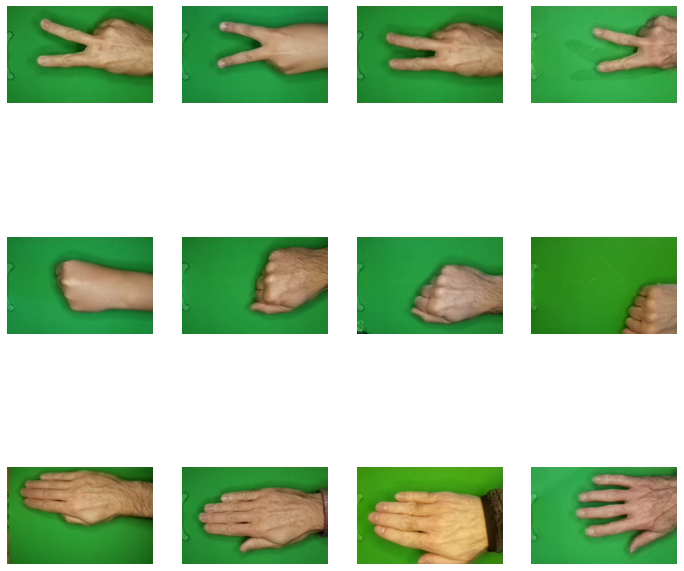

In [3]:
# 2.a. Show Folder sructure and 5 data sample
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Menampilkan struktur folder
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:
            print('{}{}'.format(subindent, f))

print('Struktur Folder Dataset:\n')
list_files(base_dir)

print('\n')

# Menampilkan sample data 
nbaris = 3
nkolom = 4

img_index = 0

fig = plt.gcf()
fig.set_size_inches(nbaris * 4, nkolom * 3)

img_index += 4

sample_gunting  = [os.path.join(scissors_dir, fname)
                  for fname in scissors_file[img_index-4:img_index]]
sample_batu     = [os.path.join(rock_dir, fname)
                  for fname in rock_file[img_index-4:img_index]]
sample_kertas   = [os.path.join(paper_dir, fname)
                  for fname in paper_file[img_index-4:img_index]]

for i, img_path in enumerate(sample_gunting+sample_batu+sample_kertas):
  sp = plt.subplot(nbaris, nkolom, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

print('Data Sample:\n')
plt.show()

In [4]:
# 2.b. Menghitung jumlah data
print('Total Paper Images: ', len(paper_file))
print('Total Rock Images: ', len(rock_file))
print('Total Scissors Images: ', len(scissors_file))
print('\n')
print('Total Images: ', len(paper_file)+len(rock_file)+len(scissors_file))

Total Paper Images:  712
Total Rock Images:  726
Total Scissors Images:  750


Total Images:  2188


### 3. Pre-processing Data
Pada tahapan ini kita akan membagi dataset menjadi train set dan validation set dengan ukuran validation set 40% dari total dataset (data training memiliki 1312 sampel, dan data validasi sebanyak 876 sampel) sebagai bahan pre-processing data menggunakan image augmentation

In [5]:
# 3.a. Metode split data yang dipilih menggunakan split folder
!pip install split-folders

import splitfolders

splitfolders.ratio(base_dir, output=base_dir, seed=1337, ratio=(.6, .4), group_prefix=None)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

train_paper_dir = os.path.join(train_dir, 'paper')
train_rock_dir = os.path.join(train_dir, 'rock')
train_scissors_dir = os.path.join(train_dir, 'scissors')

validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

Copying files: 2188 files [00:00, 3740.99 files/s]


In [6]:
# 3.b. Hitung proporsi data apakah sudah sesuai
print('Total Train Images: ',len(os.listdir(train_paper_dir))+len(os.listdir(train_rock_dir))+len(os.listdir(train_scissors_dir)))
print('Total Validation Images: ',len(os.listdir(validation_paper_dir))+len(os.listdir(validation_rock_dir))+len(os.listdir(validation_scissors_dir)))

Total Train Images:  1312
Total Validation Images:  876


In [7]:
# 3.c. Pastikan tensorflow di Google Colab sudah versi 2 ke atas
import tensorflow as tf
print(tf.__version__)

2.5.0


In [8]:
# 3.d. Pre-processing data menggunakan image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range = 0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    brightness_range=[0.5,1.5],
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range = 0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    brightness_range=[0.5,1.5],
                    fill_mode = 'nearest')

In [9]:
# 3.e. Persiapan data latih
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


### 4. Model Selection : CNN
Setelah data siap, maka kita siap membangun arsitektur model menggunakan CNN.Teknik CNN dipilih karena sangat cocok untuk problem klasifikasi gambar.

In [10]:
model = tf.keras.models.Sequential([                  
    # Convolution Layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    # Hidden Layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),

    # Output Layer
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

### 5. Model Training
Tahapan Untuk melatih model hingga mendapatkan skor akurasi yang baik

Epoch 1/20
25/25 - 40s - loss: 1.1808 - accuracy: 0.3600 - val_loss: 1.0827 - val_accuracy: 0.5063
Epoch 2/20
25/25 - 8s - loss: 1.1077 - accuracy: 0.4300 - val_loss: 1.0774 - val_accuracy: 0.3625
Epoch 3/20
25/25 - 8s - loss: 1.0828 - accuracy: 0.4475 - val_loss: 1.2134 - val_accuracy: 0.3625
Epoch 4/20
25/25 - 8s - loss: 1.0522 - accuracy: 0.5175 - val_loss: 1.0586 - val_accuracy: 0.3562
Epoch 5/20
25/25 - 8s - loss: 0.9192 - accuracy: 0.5975 - val_loss: 0.6390 - val_accuracy: 0.7312
Epoch 6/20
25/25 - 8s - loss: 0.6803 - accuracy: 0.7362 - val_loss: 0.5721 - val_accuracy: 0.7750
Epoch 7/20
25/25 - 8s - loss: 0.6838 - accuracy: 0.7063 - val_loss: 0.8767 - val_accuracy: 0.6062
Epoch 8/20
25/25 - 8s - loss: 0.6444 - accuracy: 0.7250 - val_loss: 0.4872 - val_accuracy: 0.8250
Epoch 9/20
25/25 - 8s - loss: 0.4728 - accuracy: 0.8238 - val_loss: 0.6142 - val_accuracy: 0.7188
Epoch 10/20
25/25 - 8s - loss: 0.5613 - accuracy: 0.8238 - val_loss: 0.5664 - val_accuracy: 0.7437
Epoch 11/20
25/25 

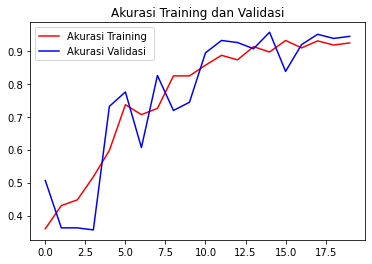

<Figure size 432x288 with 0 Axes>

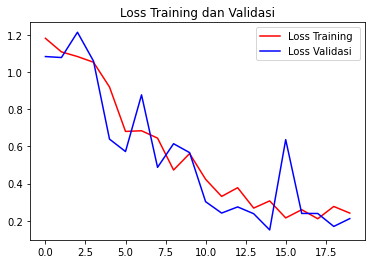

<Figure size 432x288 with 0 Axes>

In [11]:
# 5.a. Kompilasi model
model.compile(loss = 'categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# 5.b. Model training
history=model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=5, 
    verbose=2,
    )

# 5.c. Hasil training akan ditampilkan dalam bentuk grafik
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Grafik akurasi training vs akurasi validasi
plt.plot(epochs, acc, 'r', label='Akurasi Training ')
plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')
plt.title('Akurasi Training dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

# Grafik loss training vs loss validasi
plt.plot(epochs, loss, 'r', label='Loss Training ')
plt.plot(epochs, val_loss, 'b', label='Loss Validasi')
plt.title('Loss Training dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

### 6. Ujicoba Model
Pada tahap terakhir ini kita akan melakukan ujicoba model yang telah kita buat untuk memprediksi gambar bentuk tangan. Di sini kita dapat upload file image dengan backgrund hijau mengingat dataset yang tersedia masih sebatas image dengan background hijau

Saving f.png to f.png
f.png
Paper


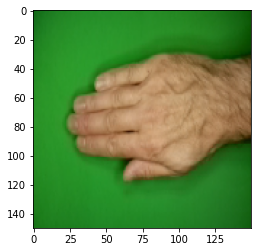

In [22]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0][0]==1:
    print('Paper')
  elif classes[0][1]==1:
    print('Rock')
  elif classes[0][2]==1:
    print('Scissors')
  else:
    print('Unknown')

# Evaluasi Submission

## Kriteria
1.   Dataset Dicoding : **Terpenuhi**
2.   Dataset di Split jadi *train set* dan *validation set* : **Terpenuhi**
3.   Ukuran *validation set* harus **40%** : **Terpenuhi**
4.   Harus implementasi augmentasi gambar : **Terpenuhi**
5.   Menggunakan **image data generator** : **Terpenuhi**
6.   Model harus menggunakan **model sequential** : **Terpenuhi**
7.   Pelatihan model tidak melebihi **30 menit** : **Terpenuhi**
8.   Program di kerjakan pada **Google Colaboratory** : **Terpenuhi**
9.   Akurasi model **minimal 85%** : **Terpenuhi**
10.  Dapat memprediksi gambar yang diungah ke Google Colab : **Terpenuhi**
11.  Menambahkan data diri : **Terpenuhi**

## Saran


1.   Akurasi model **di atas 85%** : **Terpenuhi 94%**
2.   Menggunakan **lebih dari 1 hidden layer** : **Terpenuhi 2 Hidden Layer**
3.   Menerapkan **lebih banyak augmentasi gambar** : **Terpenuhi Lebih dari 8**
4.   Menggunakan *optimizer* dan *loss function* lain : **Terpenuhi Categorical_Crossentropy dan dan rmsprop optimizer**

## Tips


1.   *Loss Function* : **Categorical_Crossentropy**
2.   Membagi *image data generator* sesuai jumlah label : **Terpenuhi**
2.   *Export project* sebagai berkas *.ipynb* : **Terpenuhi**








# Penutup
Demikian Project Klasifikasi Gambar menggunakan Model CNN yang dapat saya susun sebagai submission syarat kelulusan kelas Dicoding Belajar Machine Learning untuk Pemula. Terimakasih atas kesempatan dan waktu Review nya